In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from glob import glob
import torch
import os
import sys
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

## data prepare

### 1. 数据和标签读入; 2. 训练数据和测试数据够建;由于数据量较少, 测试和训练集有交叉. 3. 模型数据数据构建, batch_size设定为3

In [2]:
data_path_folder = "data-20230722"
data = []
labels = []
for filename in glob(data_path_folder + "/*"):
    if not filename.endswith(".csv"):
        continue
    with open(os.path.join(filename), 'r') as f:
        lines = f.readlines()
        sample_data = [[[float(line) for line in lines]]]
        data.append(sample_data)
        label_str = filename.split('/')[1].split('-')[0]
        label = 1 if label_str == "pca" else 0
        labels.append(label)
        
for i in range(len(data)):
    data[i] = torch.tensor(data[i])
    labels[i] = torch.tensor(labels[i])
    

from torch.utils.data import Dataset, DataLoader

batchsize = 3
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y


train_size = 30
test_size = 21

dataset = MyDataset(data, labels)
train_dataset, _ = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
dataset = MyDataset(data, labels)
_, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - test_size, test_size])

# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - test_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

## model definition

### 一个包含两个卷积层的CNN

In [3]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.fc1 = nn.Linear(in_features=32*1*167, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
#         print(x.shape)
        x = x.view(-1, 32*1*167)
#         print(x.shape)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## training

### 大概训练400轮后收敛

In [5]:
import torch.optim as optim

net = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

accuracy_stat = []

for epoch in range(400):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 9:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 10))
            train_loss = running_loss
            running_loss = 0.0

            correct = 0
            total = 0
            with torch.no_grad():
                for data in train_loader:
                    images, labels = data
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            train_accuracy = correct / total
            
            correct = 0
            total = 0
            with torch.no_grad():
                for data in test_loader:
                    images, labels = data
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            test_accuracy = correct / total
#             print(epoch, train_loss, train_accuracy, test_accuracy)
            accuracy_stat.append([epoch, train_loss, train_accuracy, test_accuracy])

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
#         print(labels)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 90 %


## statistics

### 统计损失函数在训练中的收敛过程，以及准确率(训练和测试样本较少，准确率抖动太大)

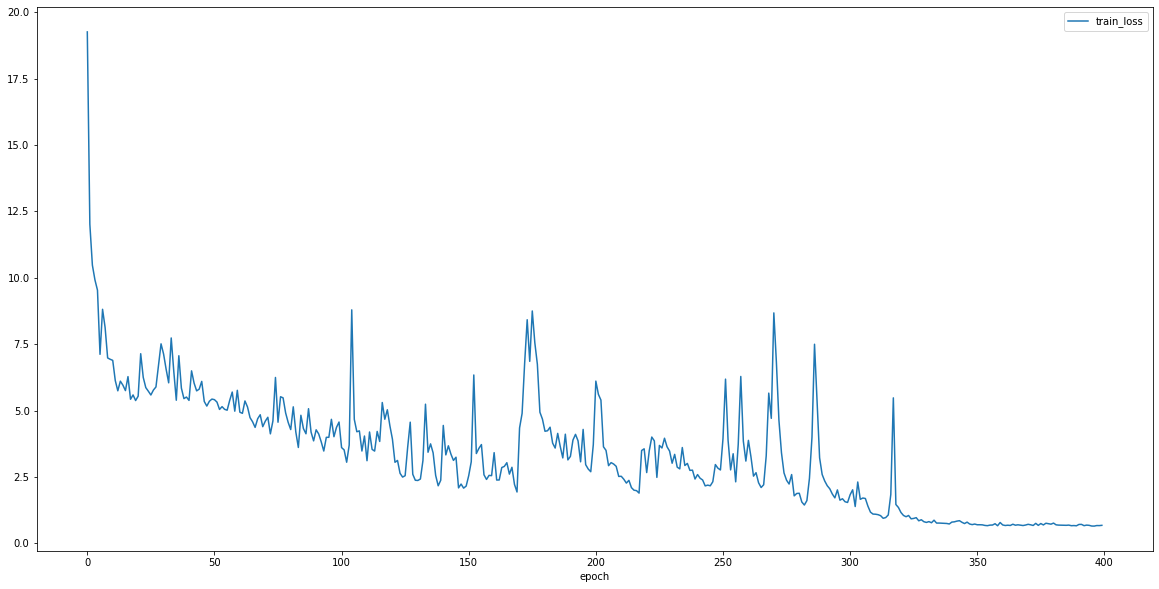

In [6]:
import pandas as pd
acc_df = pd.DataFrame(accuracy_stat, columns=['epoch', 'train_loss', 'train_accuracy', 'test_accuracy'])

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))

acc_df.plot(x = 'epoch', y = 'train_loss', ax = ax)

# acc_df.plot(x = 'epoch', y = 'train_accuracy', ax = ax)
# acc_df.plot(x = 'epoch', y = 'test_accuracy', ax = ax, secondary_y = True)